In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Split data
from sklearn.model_selection import train_test_split

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from xgboost import XGBClassifier

# URL
from urllib.parse import urlparse

/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn


def select_all_company(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursor()
    cur.execute("SELECT * FROM main.company")

    rows = cur.fetchall()
    return rows

def select_all_news_meta(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursor()
    cur.execute("SELECT * FROM main.news_meta")

    rows = cur.fetchall()
    return rows

# Read data

In [4]:
# Get data from database in a dataframe format
database = '/Users/kleomeniskogias/DataspellProjects/Mycodes/9Fin/Data/db.sqlite3'
conn = create_connection(database)

companies = select_all_company(conn)
news_meta = select_all_news_meta(conn)


companies_df = pd.DataFrame(companies, columns = ['id', 'name', 'description', 'location', 'website'])
news_meta_df = pd.DataFrame(news_meta, columns = ['id', 'url', 'published_at', 'company_id', 'label'])

# Get data from jsonl file
with open('/Users/kleomeniskogias/DataspellProjects/Mycodes/9Fin/Data/titles.jsonl', 'r') as json_file:
    json_list = list(json_file)

    json_df = pd.DataFrame(columns = ['title', 'id'])
for json_str in json_list:
    result = json.loads(json_str)
    json_df = json_df.append(result, ignore_index=True)

/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_10708/2131190086.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  json_df = json_df.append(result, ignore_index=True)
/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_10708/2131190086.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  json_df = json_df.append(result, ignore_index=True)
/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_10708/2131190086.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  json_df = json_df.append(result, ignore_index=True)
/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_10708/2131190086.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [8]:
print(companies_df.shape, news_meta_df.shape, json_df.shape)

(561, 5) (859, 5) (859, 2)


# Companies

In [9]:
companies_df.head()

,id,name,description,location,website
0,2236,Diversified Healthcare Trust,Healthcare Real Estate Investment Trust,United States,https://www.dhcreit.com/home/default.aspx
1,2748,Nathan's Famous,Operates a chain of fast food restaurants,United States,https://www.nathansfamous.com/
2,663,Dufry,Travel retailer,Switzerland,http://www.dufry.com/
3,1169,Ocado Ltd.,Online supermarket,United Kingdom,https://www.ocado.com/
4,1924,Adler Group,Owns a portfolio of commercial and residential...,Germany,https://www.ado.properties/websites/ado/Englis...


In [10]:
# Basic data investigation
# Info
print("------------ Info -------------")
print(companies_df.info())

# Missing values
print("------------ Missing values -------------")
for col in companies_df.columns:
    print(col)
    print(companies_df[companies_df[col] == ''].shape[0])

# Distribution of countries
print("------------ Location -------------")
print(companies_df['location'].value_counts())

# Check that each company is found once - however we might have the same company twice with slightly differentiated names
print("------------ Max Frequency of company names -------------")
print(companies_df['name'].value_counts().max())

------------ Info -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           561 non-null    int64 
 1   name         561 non-null    object
 2   description  561 non-null    object
 3   location     561 non-null    object
 4   website      561 non-null    object
dtypes: int64(1), object(4)
memory usage: 22.0+ KB
None
------------ Missing values -------------
id
0
name
0
description
0
location
2
website
1
------------ Location -------------
United States           235
United Kingdom           71
Germany                  34
France                   29
Italy                    21
Spain                    20
Sweden                   17
Canada                   12
Netherlands              11
Switzerland              11
Norway                   10
Greece                    9
Ireland                   9
Finland                   8
Belg

In [11]:
# Checks - # TODO
# 1. That we do not have the same company twice, with slightly differentiated name
# 2. That we do not have any missing values

# News meta

In [5]:
news_meta_df.head()

,id,url,published_at,company_id,label
0,1b26de1d-0c7e-49c2-94d7-2db9d187aaed,https://www.dhcreit.com/news/press-release-det...,2021-04-08 12:01:45.346207,2236,CALENDAR
1,fdd95479-f76f-41e3-92f7-f9fcaa025931,https://nathansfamous.gcs-web.com/news-release...,2021-11-05 12:34:06.248918,2748,RESULTS
2,d3207342-6972-4ec9-97f3-a4c5e3511ecf,https://www.dufry.com/en/press_release/2021-06...,2021-06-10 05:04:55.296493,663,PRESS RELEASE
3,b3b6f4b8-1a67-4efe-af51-a43aed8dc1b2,http://www.londonstockexchange.com/exchange/ne...,2018-12-13 07:02:16.113445,1169,RESULTS
4,bc09685e-1b3a-4afa-b9c7-c210c35babbc,https://twitter.com/JackSidders/status/1456301...,2021-11-04 17:29:14.640525,1924,PRESS RELEASE


<AxesSubplot: xlabel='published_at_month'>

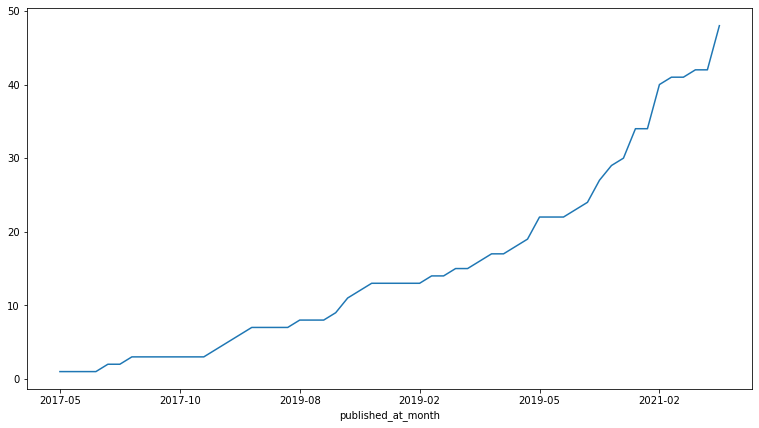

In [6]:
# Trendline of news publications
news_meta_df['published_at_month'] = news_meta_df['published_at'].apply(lambda x : x[0:7])

headlines_per_month  = news_meta_df.groupby(['published_at_month'])['id'].count().sort_values()
headlines_per_month.plot(figsize = (13,7))

# Merge data

In [7]:
# Merge 3 dataframes
print("news_meta_df shape: {}, companies_df shape: {}, json_df shape: {}".format(news_meta_df.shape, companies_df.shape,  json_df.shape))
news_meta_with_names = news_meta_df.merge(companies_df.rename(columns = {'id' : 'company_id'}), on = 'company_id', how = 'left')
print("news_meta_with_names shape: {}".format(news_meta_with_names.shape))
news_meta_with_names_and_titles = news_meta_with_names.merge(json_df, left_on = 'id',right_on = 'id')
print("news_meta_with_names_and_titles shape: {}".format(news_meta_with_names_and_titles.shape))

news_meta_df shape: (859, 6), companies_df shape: (561, 5), json_df shape: (859, 2)
news_meta_with_names shape: (859, 10)
news_meta_with_names_and_titles shape: (859, 11)


In [8]:
# Labels
news_meta_with_names_and_titles['label'].value_counts()

PRESS RELEASE    568
RESULTS          241
CALENDAR          50
Name: label, dtype: int64

## Labels distrbution per month

Try to understand whether each label is exported in specific months in the year

In [9]:
news_meta_with_names_and_titles['month'] = news_meta_with_names_and_titles['published_at'].apply(lambda x : x[5:7])

<AxesSubplot: xlabel='month'>

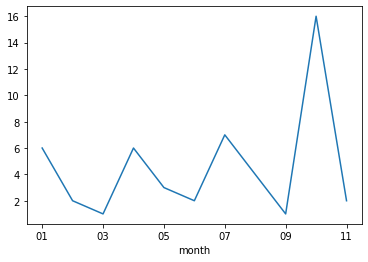

In [10]:
news_meta_with_names_and_titles[news_meta_with_names_and_titles['label'] == 'CALENDAR'].groupby(['month'])['id'].count().plot()

<AxesSubplot: xlabel='month'>

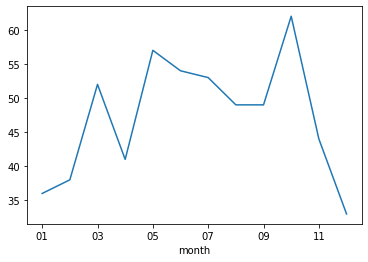

In [11]:
news_meta_with_names_and_titles[news_meta_with_names_and_titles['label'] == 'PRESS RELEASE'].groupby(['month'])['id'].count().plot()

<AxesSubplot: xlabel='month'>

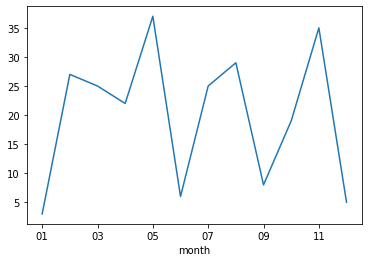

In [12]:
news_meta_with_names_and_titles[news_meta_with_names_and_titles['label'] == 'RESULTS'].groupby(['month'])['id'].count().plot()

In [81]:
# news_meta_with_names_and_titles[news_meta_with_names_and_titles['title'].str.lower().str.contains('quarter')]

In [82]:
# news_meta_with_names_and_titles[news_meta_with_names_and_titles['title'].str.lower().str.contains('release')]

# URL Processing

Process the URL so that I can export useful text from it

In [13]:
def flatten_list(nested_list:list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

def convert_list_to_string(input_list):
    text_format = ' '.join(input_list)
    return text_format

def url_to_text(input_url):
    url_list = urlparse(input_url).path.split('/')
    for i, elem in enumerate(url_list):
        url_list[i] = elem.split('-')
    url_list = flatten_list(url_list)
    url_text = convert_list_to_string(url_list).strip()
    return url_text

In [14]:
news_meta_with_names_and_titles['url_as_text'] = news_meta_with_names_and_titles['url'].apply(lambda x : url_to_text(x))
news_meta_with_names_and_titles['url_as_text']

0      news press release details 2021 Diversified He...
1      news releases news release details nathans fam...
2      en press_release 2021 06 10 dufry wins new ten...
3      exchange news market news market news detail O...
4                 JackSidders status 1456301304008122368
                             ...                        
854    documents 780029 820856 PERSBERICHT+ +HEMA+ope...
855    news events press releases detail 686 salem me...
856    global en investors pdf earnings 2021 3Q Earni...
857    news home 20190227005696 en UPC Holding BV %E2...
858    for investors press releases press release det...
Name: url_as_text, Length: 859, dtype: object

In [15]:
# Merge url and title because they are going to be the 2 fields used for text-classification
news_meta_with_names_and_titles['url_and_title'] = news_meta_with_names_and_titles['title'] + ' ' + news_meta_with_names_and_titles['url_as_text']

New Features
1. I could extract useful text from other fields as well (such as company description)

# Modelling

Case 1: (Implemented)
- clean open text
- estimate TF-IDF per title and URL
- train a classifier with TF-IDF and month

Case 2: (Not Implemented)
- fine-tune BERT model


In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

# Word lists
english_words = set(nltk.corpus.words.words())
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kleomeniskogias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kleomeniskogias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/kleomeniskogias/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [17]:
def text_cleaning(input_text:str):
    tokens = word_tokenize(input_text) # split into words
    tokens = [w.lower() for w in tokens] # convert to lower case
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]  # remove punctuation from each word
    words = [word for word in stripped if word.isalpha()] # remove remaining tokens that are not alphabetic
    words = [w for w in words if not w in stop_words] # filter out stop words
    return words


def remove_words_not_in_english(words_list:list):
    valid_words = [word for word in words_list if word in english_words]
    return valid_words

def create_tf_idf_matrix(input_series: pd.Series):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(list(input_series))
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    tf_idf_matrix = pd.DataFrame(denselist, columns=feature_names)
    return tf_idf_matrix

In [18]:
# Fromatting Options
# Option 1: keep all tokens even the ones that do not belong to English dictionary
column_to_clean = 'url_and_title'
news_meta_with_names_and_titles['clean_title'] = (news_meta_with_names_and_titles[column_to_clean].
                                                  apply(lambda x : convert_list_to_string(text_cleaning(x)))
                                                  )

# Option 2: keep only tokens that belong to English dictionary
news_meta_with_names_and_titles['clean_title2'] = (news_meta_with_names_and_titles[column_to_clean].
                                                  apply(lambda x : convert_list_to_string(remove_words_not_in_english(text_cleaning(x))))
                                                  )

In [19]:
tf_idf_matrix1 = create_tf_idf_matrix(news_meta_with_names_and_titles[column_to_clean])
print(tf_idf_matrix1.shape)
tf_idf_matrix2 = create_tf_idf_matrix(news_meta_with_names_and_titles['clean_title'])
print(tf_idf_matrix2.shape)
tf_idf_matrix3 = create_tf_idf_matrix(news_meta_with_names_and_titles['clean_title2'])
print(tf_idf_matrix3.shape)

/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(859, 4051)


/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(859, 3115)
(859, 1304)


/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Feature Engineering

In [20]:
# Month as int
news_meta_with_names_and_titles['month'] = news_meta_with_names_and_titles['month'].apply(lambda x: int(x))

# Label as int
labels_mapping_dict = {'PRESS RELEASE' : 0, 'RESULTS' : 1, 'CALENDAR' : 2}
news_meta_with_names_and_titles['label_as_int'] = news_meta_with_names_and_titles['label'].map(labels_mapping_dict)

In [21]:
news_meta_with_names_and_titles['label'].value_counts()

PRESS RELEASE    568
RESULTS          241
CALENDAR          50
Name: label, dtype: int64

In [22]:
# Build X and y datasets
tf_idf_matrix3['month'] = news_meta_with_names_and_titles['month']
X = tf_idf_matrix3
y = news_meta_with_names_and_titles['label_as_int']
print(X.shape, y.shape)

(859, 1304) (859,)


# Split Train - Test set

In [23]:
# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classifiers

In [24]:
def classify_data(model:str, X_train:pd.DataFrame, X_test:pd.DataFrame, y_train:pd.DataFrame, y_test:pd.Series):
    if model == 'LR':
        print(model)
        classifier = LogisticRegression()
    elif model == 'RF':
        print(model)
        classifier = RandomForestClassifier(random_state=7)
    elif model == 'XGBoost':
        print(model)
        classifier = XGBClassifier(max_depth = 8, n_estimators=200, learning_rate=0.1)
    else:
        print("The classifier that you chose does not exist - setting default classifier which is Logistc Regression")
        classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = round(classifier.score(X_test, y_test), 4)
    # precision = precision_score(y_test, y_pred)
    print('Accuracy of {} classifier on test set: {:.4f}'.format(model, accuracy))

    return (classifier, y_pred, accuracy) #, precision

In [25]:
for model in ['LR', 'RF', 'XGBoost']:
    cl, predictions, accuracy = classify_data(model, X_train, X_test, y_train, y_test)

LR


/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of LR classifier on test set: 0.7442
RF
Accuracy of RF classifier on test set: 0.7442
XGBoost
[19:09:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/text_analysis/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Accuracy of XGBoost classifier on test set: 0.7829


Best accuracy has been performed by XGBoost - so we do the model performance with this classifier

In [26]:
# Compare different F1-scores
from sklearn.metrics import f1_score
print(f1_score(y_test, predictions, average = None))
print(f1_score(y_test, predictions, average = 'weighted'))
print(f1_score(y_test, predictions, average = 'macro'))  # because it is unweighted
print(f1_score(y_test, predictions, average = 'micro'))

[0.85549133 0.65734266 0.51851852]
0.7703102097061858
0.6771175017803149
0.7829457364341085


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[148,  11,   0],
       [ 32,  47,   3],
       [  7,   3,   7]])

# Feature Importance

In [28]:
# Most important words for the classifier
feature_significance_df = pd.DataFrame(zip(list(cl.feature_importances_),list(X.columns))).rename(columns = {0:'Significance', 1: 'Feature'}).sort_values('Significance', ascending = False)
feature_significance_df

,Significance,Feature
406,0.065597,exchange
971,0.049720,report
294,0.046113,date
549,0.035912,home
471,0.034210,form
...,...,...
447,0.000000,find
446,0.000000,financier
444,0.000000,finance
443,0.000000,final


TODO -
1. Sparse matrix (better representation)
3. Add words from other fields